Healthcare Dataset Challenge: The task is to analyze the clinical and financial data of patients hospitalized for a certain condition. Variable names and patient identification numbers have been anonymized in this dataset. You are required to join the data given in different tables, and find insights about the drivers of cost of care. 

# Content List

1. Importing
2. Data Joining
3. Preprocessing
4. Exploratory Data Analysis
5. Scaling & Transformation
6. Model Training
7. Model Evaluation
8. SHAP Analysis






# 1. Importing

In [ ]:
# Mount google drive for google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pip install SHAP library
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.1 MB/s eta 0:00:00


In [ ]:
# Pip install Cat Boost Library
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.6 MB/s eta 0:00:00


In [ ]:
# Import relevant general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import io
import os
import os.path
from datetime import datetime, date
import functools as ft
from scipy import stats
from matplotlib import pyplot as py

# Import relevant preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy import stats

# Import relevant modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Import relevant model evaluation libraries
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf

# Import SHAP library
import shap

# 2. Data Joining

## Read in CSVs

In [ ]:
# Read in data from csvs into respective dataframes
amount = pd.read_csv('/content/drive/MyDrive/Holmusk Healthcare Data Challenge/data/bill_amount.csv')
bill = pd.read_csv('/content/drive/MyDrive/Holmusk Healthcare Data Challenge/data/bill_id.csv')
clinic = pd.read_csv('/content/drive/MyDrive/Holmusk Healthcare Data Challenge/data/clinical_data.csv')
demo = pd.read_csv('/content/drive/MyDrive/Holmusk Healthcare Data Challenge/data/demographics.csv')

In [ ]:
# Checking Functions
# df['patient_id'].nunique()
# demo['date_of_birth'].value_counts()

In [ ]:
# info() of CSVs for reference

# demographics
# #   Column               Non-Null Count  Dtype 
# ---  ------              --------------  ----- 
#  0   patient_id          3000 non-null   object
#  1   gender              3000 non-null   object
#  2   race                3000 non-null   object
#  3   resident_status     3000 non-null   object
#  4   date_of_birth       3000 non-null   object

# clinical_data
# ---  ------              --------------  -----  
#  0   id                  3400 non-null   object 
#  1   date_of_admission   3400 non-null   object 
#  2   date_of_discharge   3400 non-null   object 
#  3   medical_history_1   3400 non-null   int64  
#  4   medical_history_2   3167 non-null   float64
#  5   medical_history_3   3400 non-null   object 
#  6   medical_history_4   3400 non-null   int64  
#  7   medical_history_5   3096 non-null   float64
#  8   medical_history_6   3400 non-null   int64  
#  9   medical_history_7   3400 non-null   int64  
#  10  preop_medication_1  3400 non-null   int64  
#  11  preop_medication_2  3400 non-null   int64  
#  12  preop_medication_3  3400 non-null   int64  
#  13  preop_medication_4  3400 non-null   int64  
#  14  preop_medication_5  3400 non-null   int64  
#  15  preop_medication_6  3400 non-null   int64  
#  16  symptom_1           3400 non-null   int64  
#  17  symptom_2           3400 non-null   int64  
#  18  symptom_3           3400 non-null   int64  
#  19  symptom_4           3400 non-null   int64  
#  20  symptom_5           3400 non-null   int64  
#  21  lab_result_1        3400 non-null   float64
#  22  lab_result_2        3400 non-null   float64
#  23  lab_result_3        3400 non-null   float64
#  24  weight              3400 non-null   float64
#  25  height              3400 non-null   float64

# bill_id
# ---  ------              --------------  ----- 
#  0   bill_id             13600 non-null  int64 
#  1   patient_id          13600 non-null  object
#  2   date_of_admission   13600 non-null  object

# bill_amount
# ---  ------              --------------  -----  
#  0   bill_id             13600 non-null  int64  
#  1   amount              13600 non-null  float64

## Merge Dataframes

In [ ]:
# Merge 'bill_amount' with 'bill_id' with common 'bill_id' column
bill_2 = bill.merge(amount, on='bill_id')

In [ ]:
# Makes a new dataframe that totals the bill amounts with the same 'patient_id' and 'date_of_admission' 
bill_final = bill_2.drop(columns=['bill_id']).groupby(['patient_id','date_of_admission']).sum().reset_index().rename(columns={0:'amount'})

In [ ]:
# Checking for bill amounts
# bill_final.info()

In [ ]:
# bill_final[bill_final['patient_id']=='4e46fddfa404b306809c350aecbf0f6a'].value_counts()

In [ ]:
# bill_2[bill_2['patient_id']=='4e46fddfa404b306809c350aecbf0f6a'].groupby(['patient_id','date_of_admission']).sum()

In [ ]:
# Merge 'clinic' with 'demo' with common 'patient_id' column
clinic_final = clinic.merge(demo, left_on='id', right_on='patient_id', how='left')

In [ ]:
# Merge 'clinic_final' with 'bill_final' with common 'patient_id' and 'date_of_admission' columns
df = clinic_final.merge(bill_final, on=['patient_id','date_of_admission'])

## Drop unused 'id' columns

In [ ]:
df = df.drop(columns=['id','patient_id'])

# 3. Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 3399
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date_of_admission   3400 non-null   object 
 1   date_of_discharge   3400 non-null   object 
 2   medical_history_1   3400 non-null   int64  
 3   medical_history_2   3167 non-null   float64
 4   medical_history_3   3400 non-null   object 
 5   medical_history_4   3400 non-null   int64  
 6   medical_history_5   3096 non-null   float64
 7   medical_history_6   3400 non-null   int64  
 8   medical_history_7   3400 non-null   int64  
 9   preop_medication_1  3400 non-null   int64  
 10  preop_medication_2  3400 non-null   int64  
 11  preop_medication_3  3400 non-null   int64  
 12  preop_medication_4  3400 non-null   int64  
 13  preop_medication_5  3400 non-null   int64  
 14  preop_medication_6  3400 non-null   int64  
 15  symptom_1           3400 non-null   int64  
 16  sympto

In [ ]:
df.head()

,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,...,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,amount
0,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,...,13.2,30.9,123.0,71.3,161.0,Male,Indian,Singaporean,1976-12-19,15405.418665
1,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,...,13.8,22.6,89.0,78.4,160.0,Female,Malay,Singaporean,1978-07-20,23303.000924
2,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,...,11.2,26.2,100.0,72.0,151.0,Female,Indian,Singaporean,1967-08-14,16813.123088
3,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,1,...,13.3,28.4,76.0,64.4,152.0,Female,Chinese,PR,1967-12-06,27994.878530
4,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,0,...,12.0,27.8,87.0,55.6,160.0,Female,Others,PR,1982-07-18,10707.950907


## Derived Variables

In [ ]:
# convert 'date_of_admission' and 'date_of_discharge' columns to pd.datetime type for date calculations
df[['date_of_admission','date_of_discharge']] = df[['date_of_admission','date_of_discharge']].apply(pd.to_datetime)

# create new 'length_of_stay' column for each row based on dates of admission and discharge of patient
df['length_of_stay'] = (df['date_of_discharge'] - df['date_of_admission']).dt.days

In [ ]:
# create function that converts given date to age
def age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

In [ ]:
# create new 'age' column for each row based on 'date_of_birth' column
df['age'] = df['date_of_birth'].apply(age)

In [ ]:
# drop unused columns inplace
df = df.drop(columns=['date_of_admission','date_of_discharge','date_of_birth'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 3399
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   medical_history_1   3400 non-null   int64  
 1   medical_history_2   3167 non-null   float64
 2   medical_history_3   3400 non-null   object 
 3   medical_history_4   3400 non-null   int64  
 4   medical_history_5   3096 non-null   float64
 5   medical_history_6   3400 non-null   int64  
 6   medical_history_7   3400 non-null   int64  
 7   preop_medication_1  3400 non-null   int64  
 8   preop_medication_2  3400 non-null   int64  
 9   preop_medication_3  3400 non-null   int64  
 10  preop_medication_4  3400 non-null   int64  
 11  preop_medication_5  3400 non-null   int64  
 12  preop_medication_6  3400 non-null   int64  
 13  symptom_1           3400 non-null   int64  
 14  symptom_2           3400 non-null   int64  
 15  symptom_3           3400 non-null   int64  
 16  sympto

## Feature Engineering

'**gender**' column feature engineering

In [ ]:
df['gender'].value_counts()

Female    1586
Male      1496
m          202
f          116
Name: gender, dtype: int64

In [ ]:
# Standardise coding of races
df['gender'].replace(to_replace='m', value='Male', inplace=True)
df['gender'].replace(to_replace='f', value='Female', inplace=True)

'**race**' column feature engineering

In [ ]:
df['race'].value_counts()

Chinese    1810
Malay       707
chinese     356
Indian      230
Others      183
India       114
Name: race, dtype: int64

In [ ]:
# Standardise spelling of races
df['race'].replace(to_replace='chinese', value='Chinese', inplace=True)
df['race'].replace(to_replace='India', value='Indian', inplace=True)

'**medical_history_3**' column feature engineering

In [ ]:
df['medical_history_3'].value_counts()

0      2176
No      761
1       348
Yes     115
Name: medical_history_3, dtype: int64

In [ ]:
# Standardise binary values
df['medical_history_3'].replace(to_replace='No', value=0, inplace=True)
df['medical_history_3'].replace(to_replace='Yes', value=1, inplace=True)

# Standise 0 and 1 to be recognised as same values
df['medical_history_3'] = df['medical_history_3'].astype(float)

# 4. Exploratory Data Analysis

## Target Variable EDA

In [ ]:
# check for right side outliers
df['amount'].sort_values(ascending=False).head(20)

1226    98723.854994
639     98120.870207
1102    88873.627994
2544    87330.089425
2025    85768.525235
2518    83759.262894
1713    82444.701047
1676    80910.728630
2682    79653.720758
2063    78767.680471
2761    78282.236145
455     77358.317096
3016    73816.331782
908     73477.869010
470     68593.118633
1126    65105.609705
3207    63355.751275
2834    62820.093967
1326    62581.583634
792     62394.352550
Name: amount, dtype: float64

In [ ]:
df['amount'].sort_values().head(20)

1031    2946.100354
2302    4027.726961
454     4053.796653
1446    4208.808683
1154    4316.390771
678     4525.034647
2248    4605.032310
203     4676.066179
2600    4738.134789
2828    4785.757330
1391    4949.806331
2398    5158.920691
3371    5164.355075
2220    5190.566695
260     5312.176086
934     5372.844664
263     5418.994815
1088    5583.587628
2642    5605.018426
1245    5643.245891
Name: amount, dtype: float64

Text(0, 0.5, 'No. of Patients')

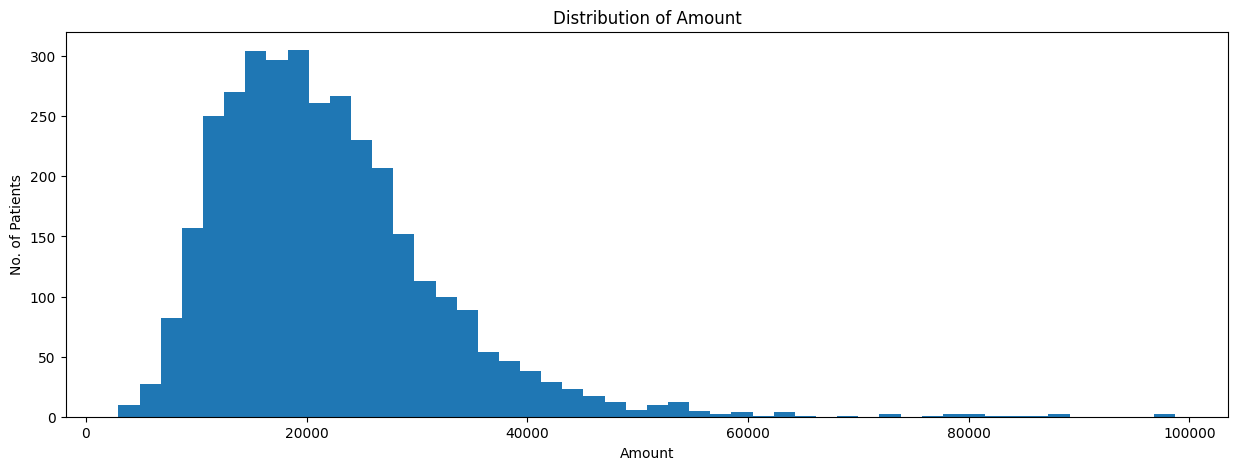

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(df['amount'],bins=50)
plt.title('Distribution of Amount')
plt.xlabel('Amount')
plt.ylabel('No. of Patients')



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='amount', ylabel='Density'>

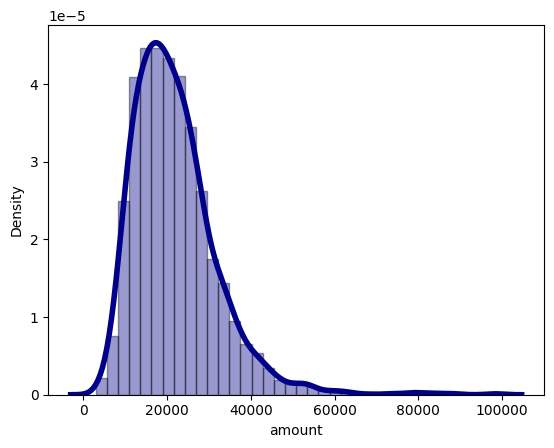

In [ ]:
sns.distplot(df['amount'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

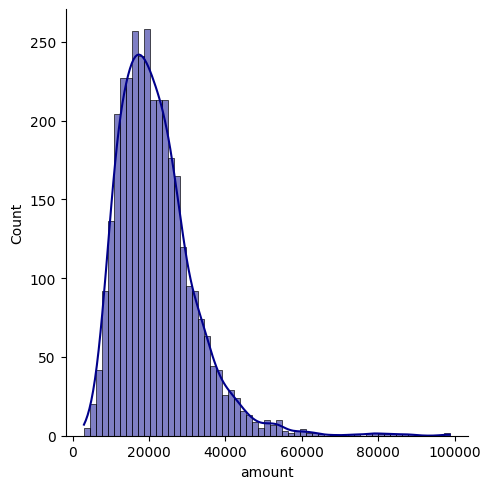

In [ ]:
sns.displot(df['amount'], kde=True, color = 'darkblue')

## Categorical Variables EDA

<Axes: title={'center': 'Gender'}>

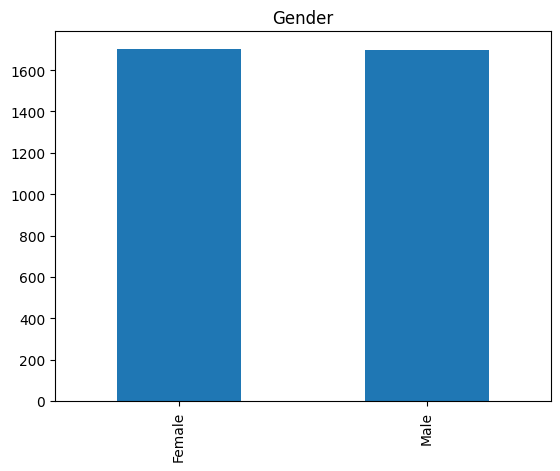

In [ ]:
df['gender'].value_counts().plot(kind='bar',title='Gender')

<Axes: title={'center': 'Race'}>

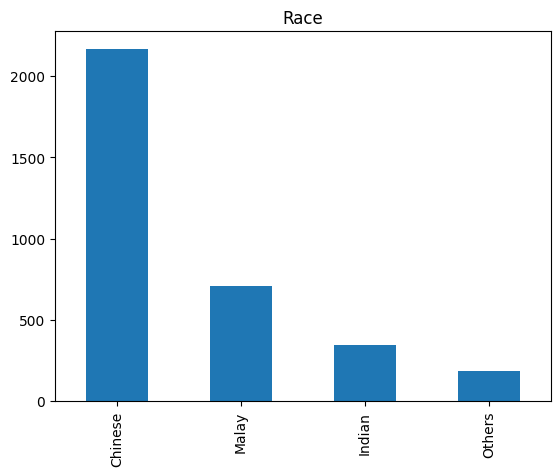

In [ ]:
df['race'].value_counts().plot(kind='bar', title='Race')

<Axes: title={'center': 'Resident Status'}>

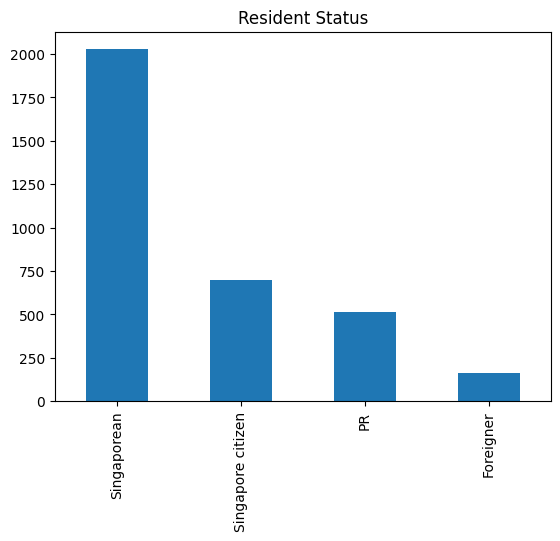

In [ ]:
df['resident_status'].value_counts().plot(kind='bar',title="Resident Status")

## Continuous Variables EDA

In [ ]:
df[['lab_result_1','lab_result_2','lab_result_3','weight','height','amount','length_of_stay','age']].describe()

,lab_result_1,lab_result_2,lab_result_3,weight,height,amount,length_of_stay,age
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,14.469882,27.431529,99.489706,78.748441,165.084412,21859.071130,11.051176,61.952353
std,1.747323,2.463844,15.254453,10.975076,6.973678,10155.336753,2.850140,14.632241
min,9.100000,19.700000,52.000000,48.000000,151.000000,2946.100354,1.000000,32.000000
25%,13.200000,25.800000,88.000000,71.200000,160.000000,14793.370831,9.000000,49.000000
50%,14.500000,27.400000,100.000000,78.900000,165.000000,20180.020614,11.000000,60.000000
75%,15.800000,29.100000,110.000000,86.300000,170.000000,26680.292435,13.000000,74.000000
max,20.300000,35.100000,150.000000,121.000000,186.000000,98723.854994,20.000000,93.000000


## Preliminary Correlation Analysis

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


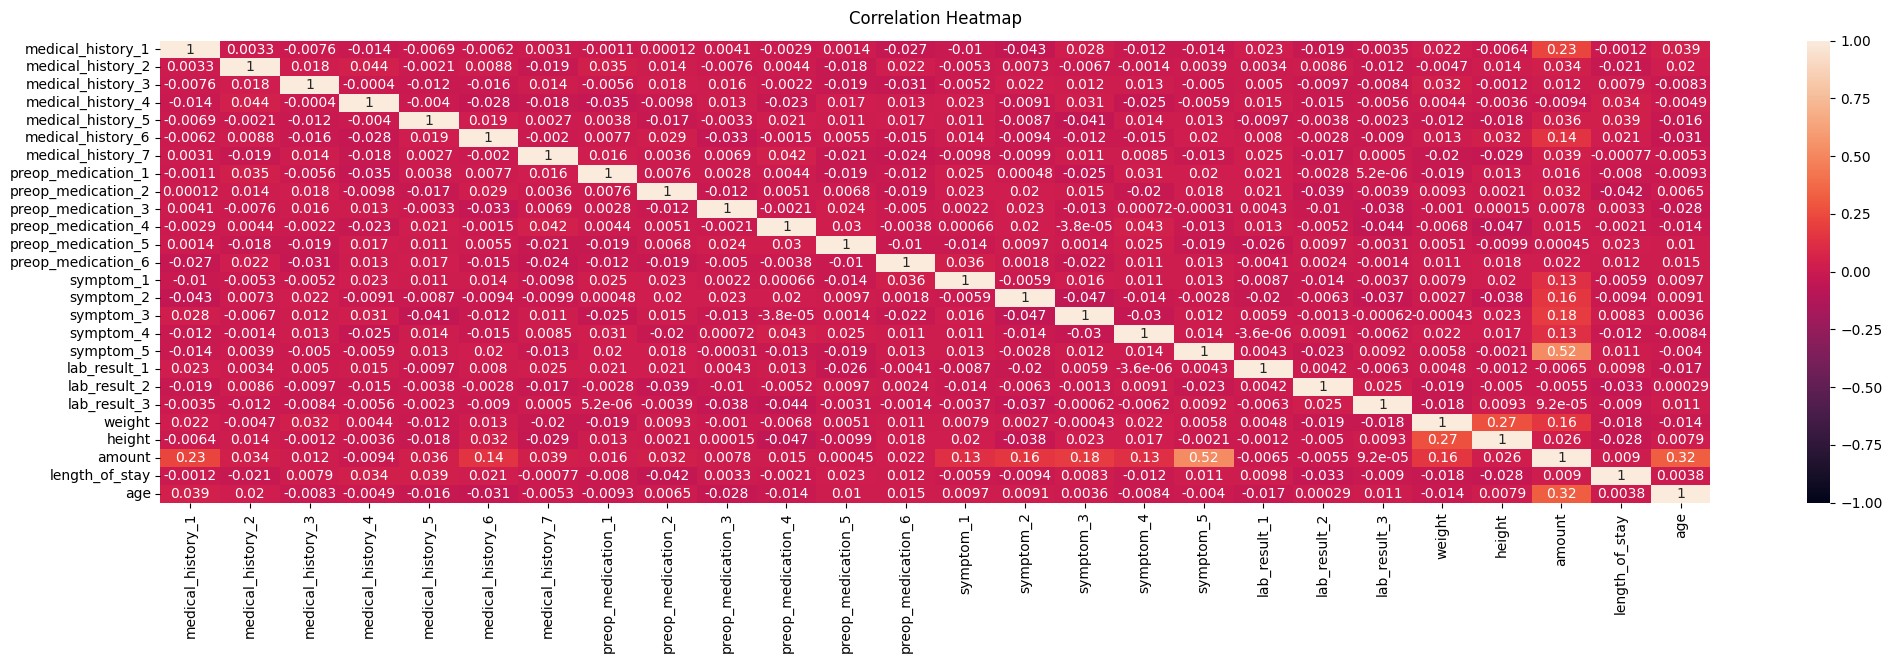

In [ ]:
plt.figure(figsize=(25, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


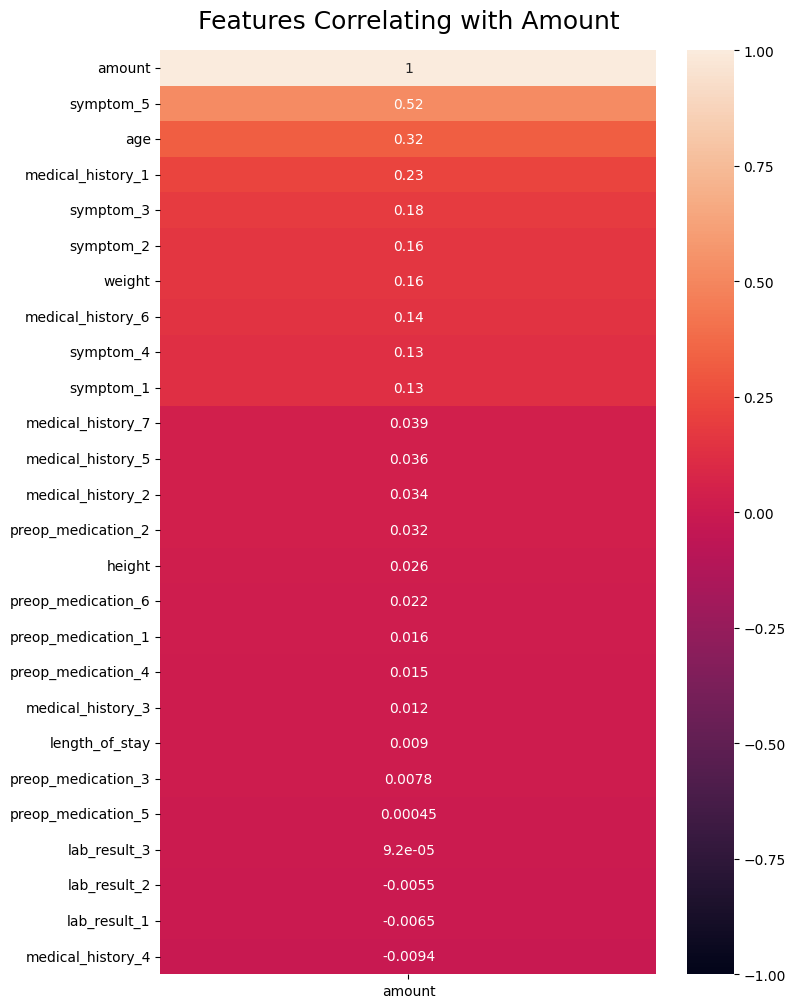

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['amount']].sort_values(by='amount', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Amount', fontdict={'fontsize':18}, pad=16);

# 5. Scaling & Transformation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 3399
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   medical_history_1   3400 non-null   int64  
 1   medical_history_2   3167 non-null   float64
 2   medical_history_3   3400 non-null   float64
 3   medical_history_4   3400 non-null   int64  
 4   medical_history_5   3096 non-null   float64
 5   medical_history_6   3400 non-null   int64  
 6   medical_history_7   3400 non-null   int64  
 7   preop_medication_1  3400 non-null   int64  
 8   preop_medication_2  3400 non-null   int64  
 9   preop_medication_3  3400 non-null   int64  
 10  preop_medication_4  3400 non-null   int64  
 11  preop_medication_5  3400 non-null   int64  
 12  preop_medication_6  3400 non-null   int64  
 13  symptom_1           3400 non-null   int64  
 14  symptom_2           3400 non-null   int64  
 15  symptom_3           3400 non-null   int64  
 16  sympto

Numerical columns scaling

In [ ]:
# Normalise for continuous variables using scikit-learn's MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['lab_result_1'] = scaler.fit_transform(df[['lab_result_1']])
df['lab_result_2'] = scaler.fit_transform(df[['lab_result_2']])
df['lab_result_3'] = scaler.fit_transform(df[['lab_result_3']])
df['weight'] = scaler.fit_transform(df[['weight']])
df['height'] = scaler.fit_transform(df[['height']])
df['length_of_stay'] = scaler.fit_transform(df[['length_of_stay']])
df['age'] = scaler.fit_transform(df[['age']])

In [ ]:
# Normalise for target variable using scikit-learn's MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['amount'] = scaler.fit_transform(df[['amount']])

In [ ]:
df[['lab_result_1','lab_result_2','lab_result_3','weight','height','amount','length_of_stay','age']].describe()

,lab_result_1,lab_result_2,lab_result_3,weight,height,amount,length_of_stay,age
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,0.479454,0.502047,0.484589,0.421212,0.402412,0.197467,0.529009,0.491022
std,0.156011,0.159990,0.155658,0.150344,0.199248,0.106030,0.150007,0.239873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.366071,0.396104,0.367347,0.317808,0.257143,0.123695,0.421053,0.278689
50%,0.482143,0.500000,0.489796,0.423288,0.400000,0.179937,0.526316,0.459016
75%,0.598214,0.610390,0.591837,0.524658,0.542857,0.247805,0.631579,0.688525
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Encoding for nominal variables

In [ ]:
# Make dataframe encoding with dummies
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 3399
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   medical_history_1                  3400 non-null   int64  
 1   medical_history_2                  3167 non-null   float64
 2   medical_history_3                  3400 non-null   float64
 3   medical_history_4                  3400 non-null   int64  
 4   medical_history_5                  3096 non-null   float64
 5   medical_history_6                  3400 non-null   int64  
 6   medical_history_7                  3400 non-null   int64  
 7   preop_medication_1                 3400 non-null   int64  
 8   preop_medication_2                 3400 non-null   int64  
 9   preop_medication_3                 3400 non-null   int64  
 10  preop_medication_4                 3400 non-null   int64  
 11  preop_medication_5                 3400 non-null   int64

In [ ]:
# Drop one encoded column for each variable to prevent bias
df = df.drop(columns=['gender_Female','race_Others','resident_status_PR'])

In [ ]:
# Make new df 'nonull' after dropping any rows with null values
nonull = df.dropna(how='any')

In [ ]:
nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 3397
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   medical_history_1                  2898 non-null   int64  
 1   medical_history_2                  2898 non-null   float64
 2   medical_history_3                  2898 non-null   float64
 3   medical_history_4                  2898 non-null   int64  
 4   medical_history_5                  2898 non-null   float64
 5   medical_history_6                  2898 non-null   int64  
 6   medical_history_7                  2898 non-null   int64  
 7   preop_medication_1                 2898 non-null   int64  
 8   preop_medication_2                 2898 non-null   int64  
 9   preop_medication_3                 2898 non-null   int64  
 10  preop_medication_4                 2898 non-null   int64  
 11  preop_medication_5                 2898 non-null   int64

# 6. Model Training

In [ ]:
# Split df into dfs with independent and dependent variables
# df_y = df['amount']
# df_x = df.drop(columns = ['amount'])

# Split nonull into dfs with independent and dependent variables
df_y = nonull['amount']
df_x = nonull.drop(columns = ['amount'])

In [ ]:
# Train-test split for independant and dependant variables
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y, test_size=0.20)

In [ ]:
# # Grid Search for best params for CatBoostRegressor
# model = CatBoostRegressor()
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# grid_search_result = model.grid_search(grid,
#                                        X=X_train,
#                                        y=y_train,
#                                        plot=True)

In [ ]:
# grid_search_result['params']

In [ ]:
# Call and fit models on train df sets

# Model & label 1 for Linear Regression
model_1 = LinearRegression(fit_intercept=False)
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)

# Model & label 2 for XGB Regressor
model_2 = xgb.XGBRegressor()
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)

# Model & label 3 for Random Forest Regressor
model_3 = RandomForestRegressor()
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)

# Model & label 4 for Gradient Boosting Regressor
model_4 = GradientBoostingRegressor()
model_4.fit(X_train, y_train)
pred_4 = model_4.predict(X_test)

# Model & label 5 for Support Vector Regression
model_5 = SVR()
model_5.fit(X_train, y_train)
pred_5 = model_5.predict(X_test)

# Model & label 6 for CatBoost Regression
model_6 = CatBoostRegressor(logging_level="Silent")
model_6.fit(X_train, y_train)
pred_6 = model_6.predict(X_test)

# Model & label 7 for LightGBM Regression
model_7 = LGBMRegressor()
model_7.fit(X_train, y_train)
pred_7 = model_7.predict(X_test)

# Model & label 8 for CatBoost Regression Tuned
model_8 = CatBoostRegressor(depth=4, l2_leaf_reg=3, learning_rate=0.1,logging_level="Silent")
model_8.fit(X_train, y_train)
pred_8 = model_8.predict(X_test)

# 7. Model Evaluation

In [ ]:
# R2 Score
score=r2_score(y_test,pred_1)
print('Linear Regression r2 score: ',score)
score=r2_score(y_test,pred_2)
print('XGB r2 score: ',score)
score=r2_score(y_test,pred_3)
print('Random Forest r2 score: ',score)
score=r2_score(y_test,pred_4)
print('Gradient Boosting r2 score: ',score)
score=r2_score(y_test,pred_5)
print('SVR r2 score: ',score)
score=r2_score(y_test,pred_6)
print('CatBoost r2 score: ',score)
score=r2_score(y_test,pred_7)
print('LightGBM r2 score: ',score)
score=r2_score(y_test,pred_8)
print('CatBoost Tuned r2 score: ',score)

Linear Regression r2 score:  0.9398573082389389
XGB r2 score:  0.9564217824462818
Random Forest r2 score:  0.8842697480531614
Gradient Boosting r2 score:  0.9648736216780281
SVR r2 score:  0.604957249572082
CatBoost r2 score:  0.9891347274165888
LightGBM r2 score:  0.9754198278196861
CatBoost Tuned r2 score:  0.9941609242012969


In [ ]:
# Mean Squared Error
print('Linear Regression MSE: ',mean_squared_error(y_test,pred_1))
print('XGB MSE: ',mean_squared_error(y_test,pred_2))
print('Random Forest MSE: ',mean_squared_error(y_test,pred_3))
print('Gradient Boosting MSE: ',mean_squared_error(y_test,pred_4))
print('SVR MSE: ',mean_squared_error(y_test,pred_5))
print('CatBoost MSE: ',mean_squared_error(y_test,pred_6))
print('LightBGM MSE: ',mean_squared_error(y_test,pred_7))
print('CatBoost Tuned MSE: ',mean_squared_error(y_test,pred_8))

Linear Regression MSE:  0.0005863084702923872
XGB MSE:  0.0004248276444542452
Random Forest MSE:  0.001128210676952686
Gradient Boosting MSE:  0.00034243384420982954
SVR MSE:  0.00385112311939201
CatBoost MSE:  0.00010592145381517606
LightBGM MSE:  0.00023962284907064966
CatBoost Tuned MSE:  5.6922952718179916e-05


In [ ]:
# Root Mean Squared Error
print('Linear Regression RMSE: ',np.sqrt(mean_squared_error(y_test,pred_1)))
print('XGB RMSE: ',np.sqrt(mean_squared_error(y_test,pred_2)))
print('Random Forest RMSE: ',np.sqrt(mean_squared_error(y_test,pred_3)))
print('Gradient Boosting RMSE: ',np.sqrt(mean_squared_error(y_test,pred_4)))
print('SVR RMSE: ',np.sqrt(mean_squared_error(y_test,pred_5)))
print('CatBoost RMSE: ',np.sqrt(mean_squared_error(y_test,pred_6)))
print('LightBGM RMSE: ',np.sqrt(mean_squared_error(y_test,pred_7)))
print('CatBoost Tuned RMSE: ',np.sqrt(mean_squared_error(y_test,pred_8)))

Linear Regression RMSE:  0.02421380743072818
XGB RMSE:  0.020611347468184733
Random Forest RMSE:  0.0335888475085509
Gradient Boosting RMSE:  0.018504968095347518
SVR RMSE:  0.062057417923984
CatBoost RMSE:  0.0102918148941368
LightBGM RMSE:  0.015479756105011786
CatBoost Tuned RMSE:  0.007544730128916469


# 8. SHAP Analysis

After model evaluation, SHAP analysis will be done for the following best performing models:
- Gradient Boosting Regressor (model_4)
- Cat Boost Regressor (model_6)
- Light GBM Regressor (model_7)
- Cat Boost Tuned Regressor (model_8)

In [ ]:
# SHAP analysis for Gradient Boosting Regressor
explainer_4 = shap.Explainer(model_4.predict, X_train)
shap_values_4 = explainer_4(X_test)
# SHAP analysis for Cat Boost Regressor
explainer_6 = shap.Explainer(model_6.predict, X_train)
shap_values_6 = explainer_6(X_test)
# SHAP analysis for Light GBM Regressor
explainer_7 = shap.Explainer(model_7.predict, X_train)
shap_values_7 = explainer_7(X_test)
# SHAP analysis for Cat Boost Tuned Regressor
explainer_8 = shap.Explainer(model_8.predict, X_train)
shap_values_8 = explainer_8(X_test)

Permutation explainer: 581it [01:06,  7.38it/s]
Permutation explainer: 581it [01:31,  5.72it/s]                         
Permutation explainer: 581it [02:10,  4.24it/s]
Permutation explainer: 581it [00:55,  8.55it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


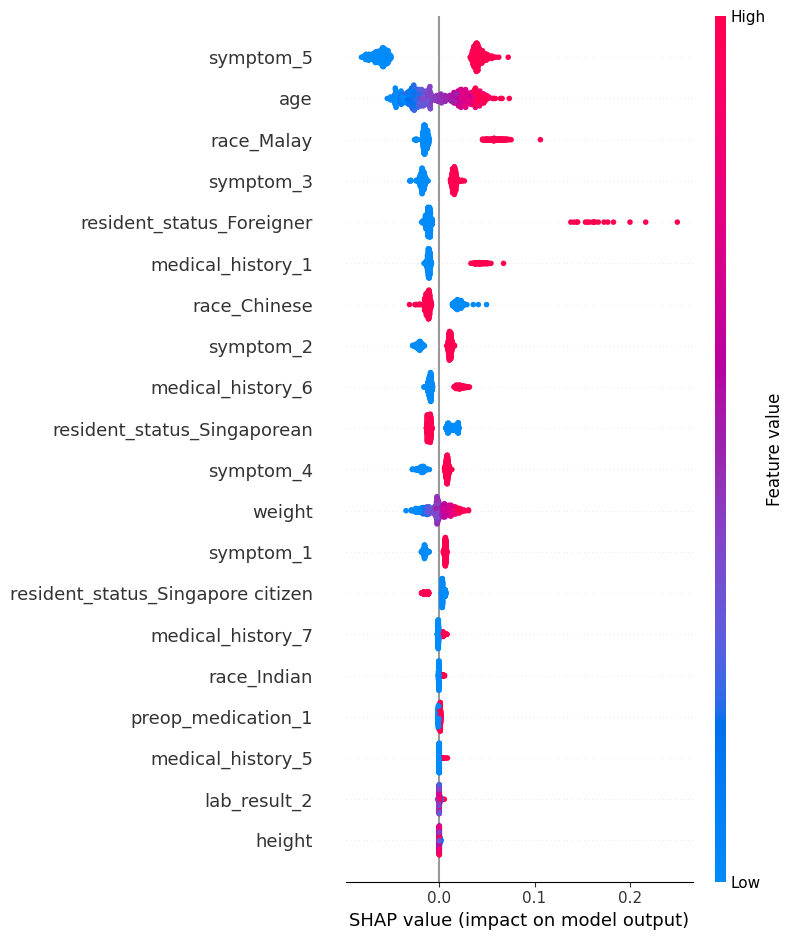

In [ ]:
# SHAP summary plot for Gradient Boosting Regressor
shap.summary_plot(shap_values_4)

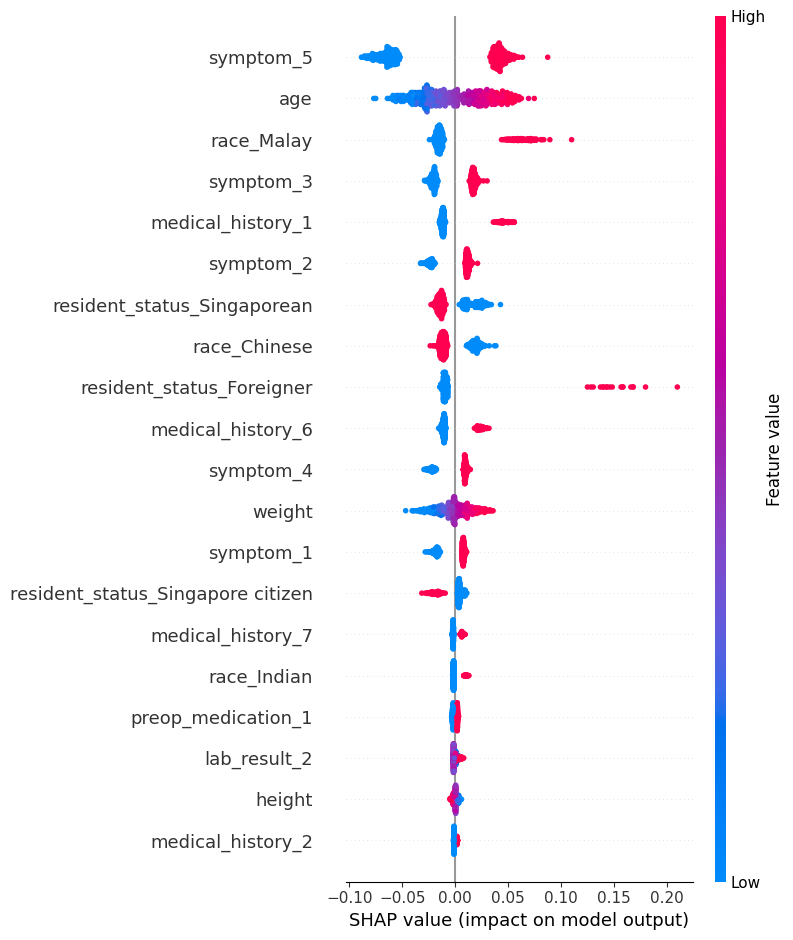

In [ ]:
# SHAP summary plot for Cat Boost Regressor
shap.summary_plot(shap_values_6)

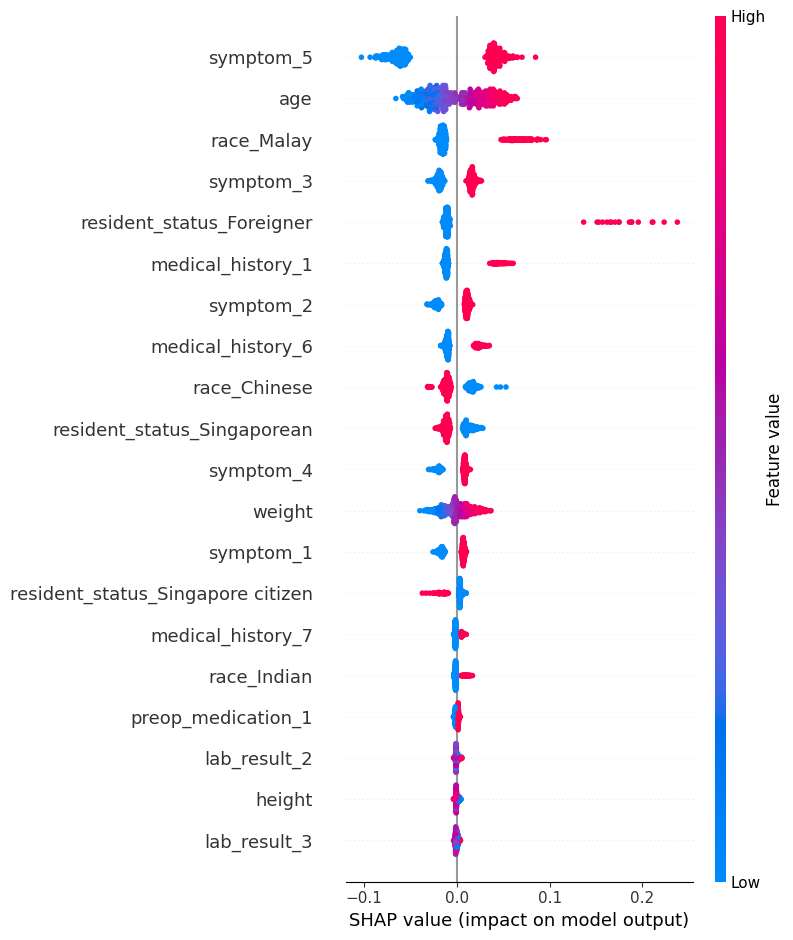

In [ ]:
# SHAP summary plot for Light GBM Regressor
shap.summary_plot(shap_values_7)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


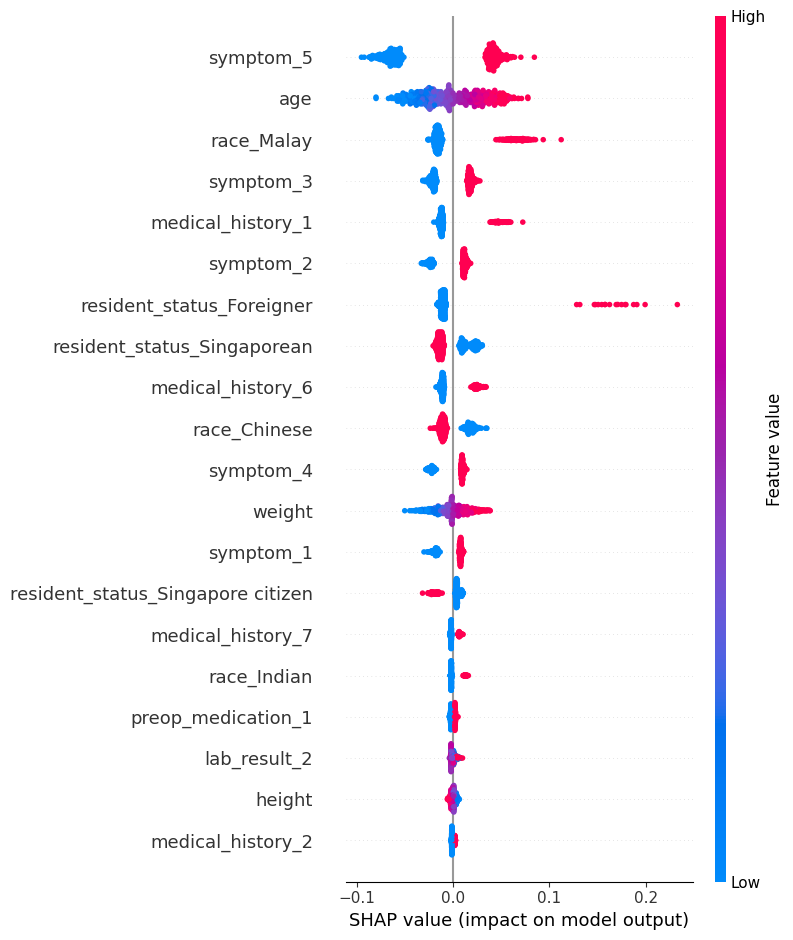

In [ ]:
# SHAP summary plot for Cat Boost Tuned Regressor
shap.summary_plot(shap_values_8)